In [1]:
!pip install lime
!pip install shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 4.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283835 sha256=d13730f6db95f3aebf7fedd6e33aebbadf7553fd1997d9fe966896747164a59b
  Stored in directory: /root/.cache/pip/wheels/fd/a2/af/9ac0a1a85a27f314a06b39e1f492bee1547d52549a4606ed89
Successfully built lime
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.1/540.1 kB 8.1 MB/s eta 0:00:00


In [2]:
# import necessary libraries
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import nltk
import re
from nltk.corpus import stopwords
from sklearn.pipeline import Pipeline
from lime.lime_text import LimeTextExplainer
import shap


In [3]:
# load the dataset from drive
from google.colab import drive
drive.mount('/content/drive')

df = pd.read_csv('/content/drive/MyDrive/Sem 3/db1.new.csv') # Access the file within your Drive

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
df.head()

,ID,Resume_str,Category,job_id,title,description,ATS_score
0,18176523,SENIOR INFORMATION TECHNOLOGY MANAGER...,INFORMATION-TECHNOLOGY,3905367422,Trademark Attorney,Junior Trademark Associate\nOur client is a to...,21
1,18176523,SENIOR INFORMATION TECHNOLOGY MANAGER...,INFORMATION-TECHNOLOGY,3887888322,Delivery Driver / CDL A required / Seasonal,PBNA $25.75 / hour\n\nCLICK HERE to view our D...,24
2,18176523,SENIOR INFORMATION TECHNOLOGY MANAGER...,INFORMATION-TECHNOLOGY,3905243094,Senior Recruiter,Hit a glass ceiling in your earning potential ...,47
3,18176523,SENIOR INFORMATION TECHNOLOGY MANAGER...,INFORMATION-TECHNOLOGY,3905323971,Order Fulfillment Coordinator,Are you ready to be a crucial part of our dyna...,51
4,18176523,SENIOR INFORMATION TECHNOLOGY MANAGER...,INFORMATION-TECHNOLOGY,3903830212,Medical Assistant Urgent Care Per Diem,"As a physician-founded and led organization, e...",38


In [5]:
# schema
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   ID           10000 non-null  int64 
 1   Resume_str   10000 non-null  object
 2   Category     10000 non-null  object
 3   job_id       10000 non-null  int64 
 4   title        10000 non-null  object
 5   description  10000 non-null  object
 6   ATS_score    10000 non-null  int64 
dtypes: int64(3), object(4)
memory usage: 547.0+ KB


In [6]:
# Download the 'punkt' resource
nltk.download('punkt')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [7]:
import nltk
nltk.download('stopwords')  # Download the 'stopwords' resource


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [8]:
# Example text preprocessing function
def preprocess_text(text):
    text = text.lower()  # Convert to lowercase
    text = re.sub(r'\d+', '', text)  # Remove digits
    text = re.sub(r'http\S+|www\S+|@\S+', '', text)  # Remove URLs, usernames, and mentions
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    text = re.sub(r'\s+', ' ', text).strip()  # Remove extra whitespaces
    tokens = nltk.word_tokenize(text)  # Tokenize the text
    tokens = [token for token in tokens if token not in stopwords.words('english')]  # Remove stopwords
    return ' '.join(tokens)  # Join the tokens back into a single string

df['cleaned_resume'] = df['Resume_str'].apply(preprocess_text)
df['cleaned_description'] = df['description'].apply(preprocess_text)




In [9]:
# Combine the features if necessary (optional)
df['combined_text'] = df['cleaned_resume'] + ' ' + df['cleaned_description']

# Save the cleaned data to a new CSV file
df.to_csv('cleaned_data.csv', index=False)
print("Data saved to cleaned_data.csv")


Data saved to cleaned_data.csv


In [10]:
import pandas as pd

# Load the cleaned data
df_cleaned = pd.read_csv('cleaned_data.csv')


In [11]:
from sklearn.model_selection import train_test_split

# Assuming 'combined_text' is your feature and 'ATS_score' is your target
X = df_cleaned['combined_text']
y = df_cleaned['ATS_score']

# Split the data into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)


In [13]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(df['combined_text'], df['ATS_score'], test_size=0.2, random_state=42)


In [14]:
# Build a pipeline
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=1000)),
    ('model', RandomForestRegressor(n_estimators=100, random_state=42))
])


In [15]:
# Train the model on the training set
pipeline.fit(X_train, y_train)


Pipeline(steps=[('tfidf', TfidfVectorizer(max_features=1000)),
                ('model', RandomForestRegressor(random_state=42))])

In [16]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Evaluate the model on the validation set
y_val_pred = pipeline.predict(X_val)
val_mse = mean_squared_error(y_val, y_val_pred)
val_rmse = val_mse ** 0.5
val_mae = mean_absolute_error(y_val, y_val_pred)

# Print validation metrics
print(f"Validation RMSE: {val_rmse}")
print(f"Validation MAE: {val_mae}")

Validation RMSE: 5.5398095274115695
Validation MAE: 4.124266666666666


In [17]:
# Evaluate the model on the test set
y_test_pred = pipeline.predict(X_test)
test_mse = mean_squared_error(y_test, y_test_pred)
test_rmse = test_mse ** 0.5
test_mae = mean_absolute_error(y_test, y_test_pred)

# Print test metrics
print(f"Test RMSE: {test_rmse}")
print(f"Test MAE: {test_mae}")

Test RMSE: 6.527383794446286
Test MAE: 5.170109999999999


In [21]:
import numpy as np

In [22]:
# LIME interpretability
class_names = ['ATS_score']
explainer = LimeTextExplainer(class_names=class_names)
idx = 0  # Index of the sample to explain
instance = X_test.iloc[idx]

# Modify the prediction to return a 2D array with probabilities
def predict_proba(texts):
    # Assuming your pipeline outputs a 1D array of predictions
    predictions = pipeline.predict(texts)
    # Create a dummy probability by subtracting predictions from 1
    # Replace this with your actual probability calculation if available
    probabilities = 1 - predictions
    # Reshape to a 2D array with two columns representing probabilities for two classes
    return np.column_stack((predictions, probabilities))

exp = explainer.explain_instance(instance, predict_proba, num_features=10)
exp.show_in_notebook()

  0%|          | 0/100 [00:00<?, ?it/s]

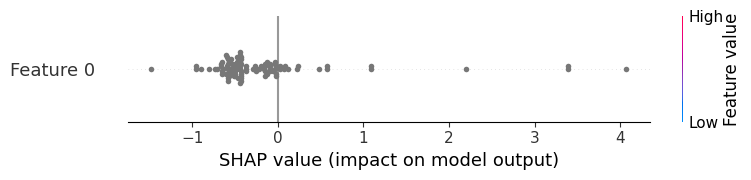

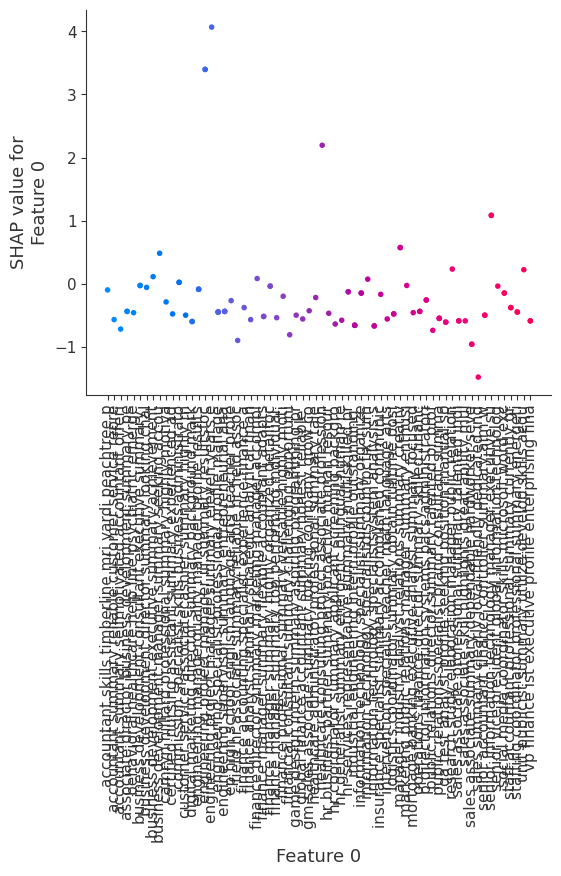

In [48]:
import shap
import numpy as np
import pandas as pd

shap.initjs()

# Convert background data to the correct format
background = X_train.sample(100, random_state=42).apply(lambda x: ' '.join(x) if isinstance(x, (list, np.ndarray)) else x).values

# Ensure the background data is a numpy array and correctly shaped
background = np.array(background).reshape(-1, 1)

# Use a wrapper function to handle the data type mismatch and ensure correct format
def predict_wrapper(data):
    # Ensure the data is a 2D array
    if isinstance(data, pd.Series):
        data = data.values.reshape(1, -1)
    elif isinstance(data, np.ndarray):
        data = data.flatten().reshape(-1, 1)

    # Convert array of strings to list
    data = data.flatten().tolist()
    predictions = pipeline.predict(data)
    return predictions

explainer = shap.KernelExplainer(predict_wrapper, background)

# Ensure X_test is in the correct format
X_test_series = np.array([' '.join(x) if isinstance(x, (list, np.ndarray)) else x for x in X_test])

# Limit the text length to ensure plots are manageable
X_test_series = np.array([text[:50] for text in X_test_series]).reshape(-1, 1)  # Reduced length further

# Calculate SHAP values for the test set, limiting to the first 100 samples
shap_values = explainer.shap_values(X_test_series[:100])

# SHAP summary plot - Limit the number of features displayed
shap.summary_plot(shap_values, X_test_series[:100], max_display=10)

# SHAP dependence plot for a specific feature - Limit number of samples shown
shap.dependence_plot(0, shap_values, X_test_series[:100])  # Change the feature index as needed
